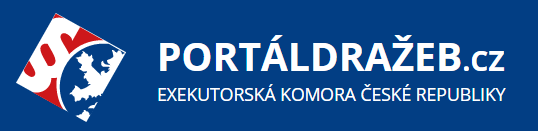

### Dynamic scraper
#### Goal
As the title suggests, the first section incorporates a data scraper. Its goal is to crawl through https://www.portaldrazeb.cz and to collect actual data about auctions and auctioneers. It also scrapes lists of auction attributes which we will subsequently use to filter the auctions with respect to location, type, etc.  
#### Problem
The problem is that the webpage has dynamic content and therefore we cannot easily extract the "static" source code as in other cases. The website also does not provide API (it actually does, however, not for us and not for the purposes we need). 
#### Solution
We use methods that handle the dynamic content - our solution is the installation of package *selenium* and setting up a *Google Chrome webdriver*. We basically open the webpage, collect its source code and navigate between pages. Thanks to this package (and the webdriver which is also included in the GitHub repository) we manage to download all the data we need. More detailed description of particular methods can be found in the class docstring and in the comments.

In [51]:
# importing the class which will do the scraping  
from dynamic_scraper import DataDownloader
down = DataDownloader() # initialising the scraper

Downloader successfully initialized!
 

    This class crawls through dynamic content of https://www.portaldrazeb.cz and collects following things:

            1) soup object for every auctioneer
            2) link to every auction + auction category (since the category is not within the auction page itself)
            3) list of all possible values from drop-down menu (auction categories, regions and districts)
    
    Subsequently it extracts soup objects of all auctions from the links collected in 2).
    


In [52]:
# link we will need
url_auctions='https://www.portaldrazeb.cz/drazby/pripravovane'

The next lines of code will scrape the data. Please do not interact with the Google Chrome window that will open in the background, just wait until it does its job and closes. The whole procedure should take a bit over 20 minutes. 

In [53]:
down.get_auction_links_and_categories(url_auctions) # takes approx. 5 minutes

100%|██████████| 57/57 [04:56<00:00,  5.20s/it]


Auction links and categories successfully downloaded! There are 1125 auctions right now.


In [56]:
down.get_items_from_dropdown_menu(url_auctions) #needs Chrome version 90 (exactly this one)

Auction categories, regions and districts successfully downloaded!


In [57]:
down.extract_auction_soups() # takes approx. 17 minutes

100%|██████████| 1125/1125 [11:39<00:00,  1.61it/s]

Soup objects successfully appended to auction_links_and_categories.


### Data processor
#### 

#### Goal
The second section contains the data processor. It accepts BeautifulSoup objects scraped in first part and extracts information about every auction. Closer information of what is collected can be found in the class description.
#### Problem
Variables in which we are interested in are scattered through the long strings. Luckily, the structure of string remains fairly consistent from auction to auction and mostly there is some substring preceding the desired information which we can find and look some constant amount of characters behind it. Also, there is a problem with Czech characters, which are encoded in a different way than we need them.
#### Solution
This problem demands an approach focused on specifics of every variable, so all necessary data were found, cleaned and put into Pandas dataframe and then a CSV file. 

In [58]:
import pandas as pd
import numpy as np

In [60]:
auctionslist=[]
for i in range(len(down.auction_links_and_categories)):
    soup = down.auction_links_and_categories[i][3]
    auctiondata=soup.findAll("div", {"class": "auction"})
    auctiondata=str(auctiondata[0])
    for x,y in czech.items():
        auctiondata = auctiondata.replace(x, y)#here the source-Czech dictionary is used
    auctiondata=auctiondata.replace('&quot;','"')
    #auctiondata=auctiondata.replace('"','')
    title=auctiondata[(auctiondata.index("title") + len("title")+3):]
    title=title[:title.index("category")-3]
    districtname=auctiondata[(auctiondata.index("district_name") + len("district_name")+3):(auctiondata.index("district_name") + len("district_name")+33)]
    districtname=districtname[:districtname.index('"')]
    if districtname=="' ')": districtname=np.nan#some auctions do not have this parameter, so it returns these characters
    regionname=auctiondata[(auctiondata.index("county_name")+ len("county_name")+3):(auctiondata.index("county_name")+ len("county_name")+33)]
    regionname=regionname[:regionname.index('"')]
    if regionname=="<th>Okres</th>\n<td v-text=":regionname=np.nan#like districtname, it is not everywhere
    auctioneer=auctiondata[(auctiondata.index("auctioneer_office") + len("auctioneer_office")+30):]
    auctioneer=auctioneer[:auctioneer.index("addresses")-3].replace(" ","_")
    auctioneer=" ".join(auctioneer.split("_", 2)[:2])
    number=auctiondata[(auctiondata.index('voluntary')-17):(auctiondata.index('voluntary')-3)].replace(':','').replace('"', '')
    estimated_price=auctiondata[(auctiondata.index("estimated_price") + len("estimated_price")+2):]
    estimated_price=estimated_price[:estimated_price.index("item_price")-2]
    reserve_price=auctiondata[auctiondata.index("item_price")+12:]
    reserve_price=reserve_price[:reserve_price.index("minimal_bid")-2]
    time=auctiondata[auctiondata.index("start_at")+11:auctiondata.index("start_at")+27]
    time=time.split("T")
    location=auctiondata[auctiondata.index("location_coords")+29:auctiondata.index("location_coords")+70]
    latitude=location[:10]
    if latitude[0]!="4" and latitude[0]!="5":#some do not provide coordinates, this is just filtering
        latitude=np.nan
    longitude=location[23:33]
    if longitude[0]!="1": #like latitude
        longitude=np.nan
    phone=auctiondata[auctiondata.index("phone_number")+len("phone_number")+3:auctiondata.index("phone_number")+len("phone_number")+12]
    email=auctiondata[auctiondata.index("email")+8:auctiondata.index("children")-3]                        
    link = down.auction_links_and_categories[i][0]
    category = down.auction_links_and_categories[i][1][0]
    try: subcategory = down.auction_links_and_categories[i][1][1]
    except: subcategory = "-"
    auction=[]
    auction.extend([auctioneer,phone,email,districtname,regionname,latitude,longitude,title,time[0],time[1],category,subcategory,number,estimated_price,reserve_price,link])
    auctionslist.append(auction)

In [61]:
czech = {'\\u00e1': 'á',"\\u010d":"č","\\u010f":"ď","\\u00e9":"é","\\u011b":"ě","\\u00ed":"í","\\u0148":"ň","\\u00f3":"ó","\\u0159":"ř","\\u0161":"š","\\u0165":"ť","\\u00fa":"ú","\\u016f":"ů","\\u00fd":"ý","\\u017e":"ž","\\u00c1":"Á","\\u00c4":"Ä","\\u010c":"Č","\\u010e":"Ď","\\u00c9":"É","\\u011a":"Ě","\\u00cd":"Í","\\u0147":"Ň","\\u00d3":"Ó","\\u0158":"Ř","\\u0160":"Š","\\u0164":"Ť","\\u00da":"Ú","\\u016e":"Ů","\\u00dd":"Ý","\\u017d":"Ž"}
#necessary to translate groups of characters from the source code to Czech characters
for x,y in czech.items():
    auctiondata = auctiondata.replace(x, y)

In [62]:
for i in range(len(auctionslist)):
    for j in range(len(down.regions_and_districts)):
        for k in range(len(down.regions_and_districts[j][1])):
            if down.regions_and_districts[j][1].count(auctionslist[i][4])==1:
                auctionslist[i][4]=down.regions_and_districts[j][0]

In [63]:
auctions = pd.DataFrame(auctionslist)
auctions.columns = ["Auctioneer","Phone","E-mail","District","Region","Latitude","Longitude","Title of auction",
                    "Beginning_on","Beginning_at","Category","Subcategory","Auction_code","Estimated_price","Reserve_price",
                    "Link"]
auctions.to_csv('auctionslist.csv', index = False)

In [64]:
auctions

,Auctioneer,Phone,E-mail,District,Region,Latitude,Longitude,Title of auction,Beginning_on,Beginning_at,Category,Subcategory,Auction_code,Estimated_price,Reserve_price,Link
0,Skoupá Kateřina,515536375,podatelna@exekutor-skoupa.cz,Znojmo,Jihomoravský kraj,48.8784087,16.2895316,Ideální 1/2 pozemku v Čejkovicích - okr. Znojmo,2021-09-06,08:00,Nemovitosti,Pozemek,166EX16/14-340,9085,6057,https://www.portaldrazeb.cz/drazba/166ex16-14-...
1,Suchánek Michal,266032031,suchanek@exekucepraha.cz,Praha,Hlavní město Praha,50.0763558,14.4734914,Dražba spoluvlastnického podílu ve výši 1/12 n...,2021-09-06,09:00,Nemovitosti,Pozemek,EX05617/14-170,21000,14000,https://www.portaldrazeb.cz/drazba/220ex05617-...
2,Suchánek Michal,266032031,suchanek@exekucepraha.cz,Praha,Hlavní město Praha,50.0763558,14.4734914,Dražba spoluvlastnického podílu ve výši 1/4 na...,2021-09-06,09:00,Nemovitosti,Pozemek,EX03742/18-172,79000,52667,https://www.portaldrazeb.cz/drazba/220ex03742-...
3,Svoboda Jan,585750843,podatelna@exekutor-svoboda.cz,Náchod,Královéhradecký kraj,50.3615314,15.8727806,"Pozemek o velikosti 150,00 m2, Rtyně, podíl 1/...",2021-09-06,09:00,Nemovitosti,Pozemek,64EX654/12-313,24000,12000,https://www.portaldrazeb.cz/drazba/164ex654-12...
4,Suchánek Michal,266032031,suchanek@exekucepraha.cz,NaN,NaN,NaN,NaN,Dražba movitých věcí - 5x zmrzlinové automaty,2021-09-06,09:00,Movitosti,Elektronika,0EX02141/21-36,90000,30000,https://www.portaldrazeb.cz/drazba/220ex02141-...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120,Bohutínský Jan,499841570,podatelna@exekutor-trutnov.cz,Frýdek-Místek,Moravskoslezský kraj,NaN,NaN,Termín dražby není stanoven - 1/2 RD v Jablunk...,2038-01-19,08:30,Nemovitosti,Rodinný dům,158EX129/14,435000,290000,https://www.portaldrazeb.cz/drazba/158ex129-14...
1121,Souček Kamil,491422020,podatelna@soucek-exekutor.cz,Benešov,Středočeský kraj,NaN,NaN,"osobní automobil Škoda Octavia, TDi, 2012",2038-01-19,09:00,Movitosti,Auto-moto,083EX806/15-71,210000,0,https://www.portaldrazeb.cz/drazba/083ex806-15...
1122,Bohutínský Jan,499841570,podatelna@exekutor-trutnov.cz,Trutnov,Královéhradecký kraj,NaN,NaN,Termín dražby není stanoven 1/2 pohostinského ...,2038-01-19,09:30,Nemovitosti,Rodinný dům,158EX1248/13,1750000,1166667,https://www.portaldrazeb.cz/drazba/158ex1248-1...
1123,Tvrdková Jana,244400604,exekutorskyurad@tvrdkova.cz,Benešov,Středočeský kraj,NaN,NaN,Dražba zabavených movitých věcí povinného - DR...,2038-01-19,13:00,Movitosti,Elektronika,095EX2043/13,0,0,https://www.portaldrazeb.cz/drazba/095ex2043-1...


### Data filter

In [65]:
import pandas as pd
import ipywidgets as widgets
from IPython.display import HTML
import matplotlib.pyplot as plt

In [66]:
auctions = pd.read_csv("auctionslist.csv")
auctions=auctions.set_index("Auction_code")

In [67]:
auctions = auctions[["Title of auction","Category","Subcategory","Beginning_on","Beginning_at","Estimated_price","Reserve_price","Link","Auctioneer","Phone","E-mail","Region","District","Latitude","Longitude"]]

In [68]:
# formatting auction links to html (in order to create hyperlinks)
auctions['Link'] = auctions['Link'].apply(lambda x: f'<a href="{x}"> more info here </a>'.format(x))

In [69]:
# preparing lists of regions and districts (values for dropdown menu)
regions_and_districts = pd.DataFrame(down.regions_and_districts,columns=["Region","Districts"])
regions = ["All"]
for i in regions_and_districts["Region"]:
    regions.append(i)
districts = ["All"]
for i in regions_and_districts["Districts"].explode():
    districts.append(i)

In [70]:
# defining function which generates unique values of a column within data frame
def unique_values_and_their_counts(df, column):
    values = df[column].value_counts().index.tolist()
    counts = df[column].value_counts().tolist()
    values_plus_counts = [values[i]+": "+str(counts[i]) for i in range(len(values))] # this is used as label in pie chart
    return values, counts, values_plus_counts

In [71]:
# controlling output
output = widgets.Output() 
category_output = widgets.Output()
auctioneer_output = widgets.Output()
# setting up the widgets
region_widget = widgets.Dropdown(
    options=regions,
    value='All',
    description='Region:')
district_widget = widgets.Dropdown(
    options=districts,
    value='All',
    description='District:')

# combining effects of both widgets
def common_filtering(region, district):
    output.clear_output() # necessary to prevent from cummulating multiple outputs
    category_output.clear_output()
    auctioneer_output.clear_output()
    if (region == "All") & (district == "All"):
        common_filter = auctions
        
    elif (region == "All"):
        common_filter = auctions[auctions["District"] == district]
        
    elif (district == "All"):
        common_filter = auctions[auctions["Region"] == region]
        
    else:
        common_filter = auctions[(auctions["Region"] == region) & 
                                  (auctions["District"] == district)]
    with output:
        display(HTML(common_filter.to_html(escape=False)))
    with category_output:
        plt.pie(unique_values_and_their_counts(common_filter,"Subcategory")[1], 
                labels = unique_values_and_their_counts(common_filter,"Subcategory")[2])
        plt.show()    
    with auctioneer_output:
        fig, ax = plt.subplots()
        plt.style.use('ggplot')

        names = unique_values_and_their_counts(common_filter,"Auctioneer")[0][:8]
        number_of_auctions = unique_values_and_their_counts(common_filter,"Auctioneer")[1][:8]

        position = range(len(names))

        plt.bar(position, number_of_auctions, color='green')
        plt.xlabel("Auctioneer")
        plt.ylabel("Number of auctions")
        plt.title("Auctioneers with most auctions")

        plt.xticks(position, names)

        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        plt.show()
        
def dropdown_region_eventhandler(change):
    common_filtering(change.new, district_widget.value)
def dropdown_district_eventhandler(change):
    common_filtering(region_widget.value, change.new)
region_widget.observe(dropdown_region_eventhandler, names='value')
district_widget.observe(dropdown_district_eventhandler, names='value')

# creating layout for widgets and output tabs
input_widgets = widgets.HBox([region_widget,district_widget])
tab = widgets.Tab([output, category_output,auctioneer_output])
tab.set_title(0, 'Auctions')
tab.set_title(1, 'Categories')
tab.set_title(2, 'Auctioneers')

# showing the result
display(input_widgets)
display(tab)

In [72]:
!pip install descartes
!pip install pyshp
from descartes import PolygonPatch
import shapefile
import matplotlib.pyplot as plt

In [73]:
sf=shapefile.Reader('districts')

In [149]:
auctions.Estimated_price[auctions.Region == regionlist[0]].mean()

1549443.8671875

In [171]:
mapsource=[]
regionlist=[]
countlist=[]
avglist=[]
startindices=[1,2,14,21,28,31,38,42,47,51,56,63,68,74]
endindices=[1,13,20,27,30,37,41,46,50,55,62,67,73,77]
for i in range(len(down.regions_and_districts)):
    regionlist.append(down.regions_and_districts[i][0])
for i in range(len(down.regions_and_districts)):
    count=auctions.Region[auctions.Region == regionlist[i]].count()
    countlist.append(count)
for i in range(len(down.regions_and_districts)):
    avgprice=auctions.Estimated_price[auctions.Region == regionlist[i]].mean()
    avglist.append(avgprice)
countlist

[128, 60, 108, 35, 36, 50, 46, 83, 121, 43, 97, 139, 101, 51]

In [158]:
max(countlist)

139

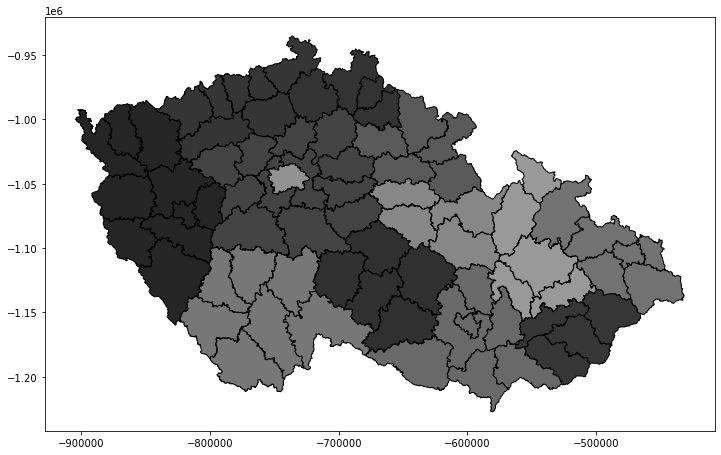

In [187]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()

for i in range(len(down.regions_and_districts)):
    for j in range(startindices[i]-1,endindices[i]):
        shade=int(countlist[i]/max(countlist)//0.01)#making integers to put in colour codes
        if shade>9:fillcolour="#{}{}{}".format(shade,shade,shade)
        else:fillcolour="#0{}0{}0{}".format(shade,shade,shade)#one-digit numbers would not work in the code
        poly=sf.shape(j).__geo_interface__
        ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#000000', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()#The lighter the colour, the more auctions there are. The region with most auctions always has shade #999999,
#other regions are coloured by their share of auctions: 10% of maximum has shade #101010, 52% has shade #525252 etc.

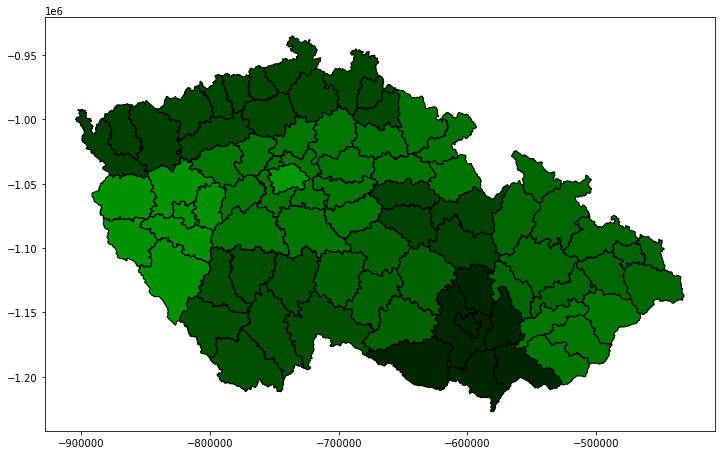

In [186]:
fig = plt.figure(figsize=(12,12)) 
ax = fig.gca()

for i in range(len(down.regions_and_districts)):
    for j in range(startindices[i]-1,endindices[i]):
        shade=int(avglist[i]/max(avglist)//0.01)
        if shade>9:fillcolour="#00{}00".format(shade)
        else:fillcolour="#000{}00".format(shade)
        poly=sf.shape(j).__geo_interface__
        ax.add_patch(PolygonPatch(poly, fc=fillcolour, ec='#000000', alpha=1, zorder=2 ))
ax.axis('scaled')
plt.show()#The lighter the colour, the more expensive auctions on average there are. Coloured by share of maximum like before. 